In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
df_raw = pd.read_csv(
    "./data/ecommerce-transaction-data.csv", 
    encoding="ISO-8859-1",
    parse_dates=['InvoiceDate']
)

In [4]:
df = df_raw.copy()

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# 1. Data engineering

## 1.1 Clean up data

**CustomerID** - It seems that there are many CustomerIDs that are NULL for some reason for what ever reason. We are going to leave out all of these rows where CustomerID is NULL

In [8]:
len(df[df["CustomerID"].isnull()])

135080

In [9]:
df = df[df["CustomerID"].notnull()]

**InvoiceNo** - Some invoice number are prefixed with a C meaning that they are cancelled. We will therefore create a new column this and convert InvoiceNo into integer

In [10]:
len(df[df['InvoiceNo'].str.isnumeric() == False])

8905

In [11]:
df['xCancelled'] = df['InvoiceNo'].str.startswith('C')

In [12]:
#df['InvoiceNo'] = df['InvoiceNo'].replace('[^0-9]+.-', '', regex=True)

df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = pd.to_numeric(df['InvoiceNo'])

**InvoiceData** - Convert date to proper datetime

In [13]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo      406829 non-null int64
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
xCancelled     406829 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 28.3+ MB


## 1.2 Handling StockItems

Taking out all the StockItems which are registered as Postage. However postage will be put into a seperate DataFrame

In [15]:
df_postage = df[df['Description'] == 'POSTAGE']

df = df[df['Description'] != 'POSTAGE']

## 1.3 Handling outliners

In [16]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,405633.000000,405633.000000,405633.000000,405633.000000
mean,560583.150385,12.089465,3.358961,15294.737566
std,13105.731435,249.059161,66.980347,1710.302540
min,536365.000000,-80995.000000,0.000000,12346.000000
25%,549130.000000,2.000000,1.250000,13969.000000
50%,561873.000000,5.000000,1.950000,15159.000000
75%,572065.000000,12.000000,3.750000,16794.000000
max,581587.000000,80995.000000,38970.000000,18287.000000


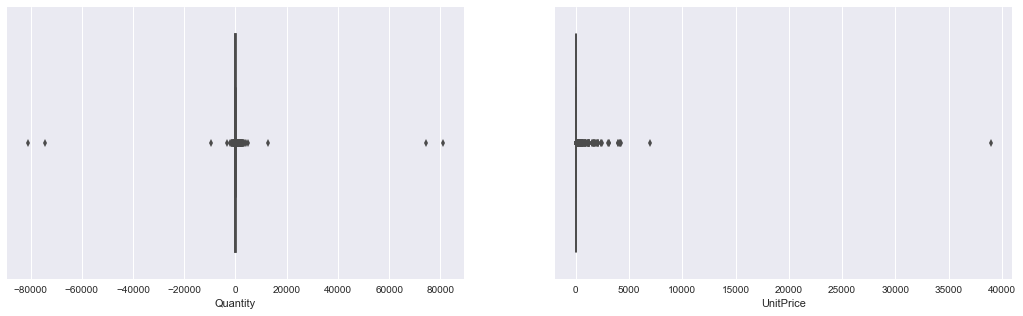

In [17]:
fig, ax = plt.subplots(figsize=(18,5), ncols=2)

sns.boxplot(x=df["Quantity"], ax=ax[0])
sns.boxplot(x=df["UnitPrice"], ax=ax[1])
plt.show()

It seems that there are some clear outliners in Quantity and UnitPrice. These might affect further analysis and will therefore be removed

In [18]:
df[df['Quantity'] < -3000].sort_values('Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,xCancelled
540422,581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,True
61624,541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,True
4287,536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,True
160145,550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom,True


In [19]:
df[df['Quantity'] > 3000].sort_values('Quantity', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,xCancelled
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,False
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,False
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,False
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,False
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom,False
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,False
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,False


In [20]:
"""
581484: Quantity is -80995
541433: Quantity is -74215
536757: Quantity is -9360

581483: Quantity is 80995
541431: Quantity is 74215
578841: Quantity is 12540
"""

df = df[~df['InvoiceNo'].isin([581484, 541433, 536757, 581483, 541431, 578841])]

In [21]:
df[df['UnitPrice'] > 3000].sort_values('UnitPrice', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,xCancelled
222681,556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,True
173391,551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029.0,United Kingdom,True
268027,560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448.0,United Kingdom,True
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France,False
422375,573079,M,Manual,-2,2011-10-27 14:15:00,4161.06,12536.0,France,True
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France,False
406404,571750,M,Manual,-1,2011-10-19 11:16:00,3949.32,12744.0,Singapore,True
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore,False
293842,562647,M,Manual,-1,2011-08-08 12:56:00,3155.95,15502.0,United Kingdom,True
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom,False


In [22]:
"""
556445: UnitPrice is 38970.00
"""

df = df[~df['InvoiceNo'].isin([556445])]

In [ ]:
fig, ax = plt.subplots(figsize=(18,5), ncols=2)

sns.boxplot(x=df["Quantity"], ax=ax[0])
sns.boxplot(x=df["UnitPrice"], ax=ax[1])
plt.show()

## Further inspection

In [ ]:
print(len(df[df["Quantity"]<=0]))
print(len(df[df["xCancelled"]==False]))

In [ ]:
df_raw[df["StockCode"]=='D']

In [ ]:
df[df['InvoiceNo'] == 539003]

In [ ]:
df.loc[df['CustomerID'] == 14527.0, ['CustomerID','StockCode']]

In [ ]:
len(df[df['xCancelled'] == True])

## 2.1 Feature engineering

**Price** - Since we have price per unit and quantity we can get the total price for that line item

In [23]:
df['xPrice'] = df['UnitPrice'] * df['Quantity']

## 2.2 Feature Correlation Analysis

Pearson goes from -1 to +1. A value of 0 would have told there is no correlation, so we shouldn’t bother looking at that attribute.

In [24]:
potentialFeatures = ['xPrice', 'UnitPrice']

# check how the features are correlated with the overall ratings

for f in potentialFeatures:
    related = df['Quantity'].corr(df[f])
    print("%s: %f" % (f,related))


xPrice: 0.496628
UnitPrice: -0.015911


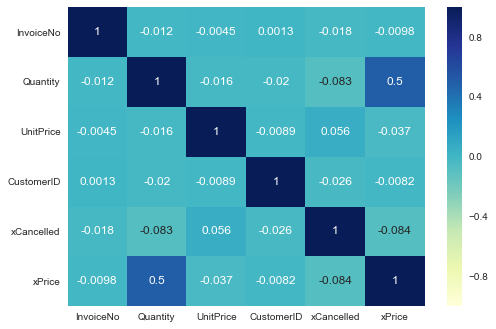

In [25]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, cmap="YlGnBu")
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405626 entries, 0 to 541908
Data columns (total 10 columns):
InvoiceNo      405626 non-null int64
StockCode      405626 non-null object
Description    405626 non-null object
Quantity       405626 non-null int64
InvoiceDate    405626 non-null datetime64[ns]
UnitPrice      405626 non-null float64
CustomerID     405626 non-null float64
Country        405626 non-null object
xCancelled     405626 non-null bool
xPrice         405626 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 31.3+ MB


## 2 Exploratory Data Analysis (EDA)


* Seaborn Gallery Example http://seaborn.pydata.org/examples/index.html

* Controlling figure aesthetics
https://seaborn.pydata.org/tutorial/aesthetics.html
* Customizing matplotlib: Using style sheets https://matplotlib.org/users/customizing.html
* sns.set https://seaborn.pydata.org/generated/seaborn.set.html


https://www.programcreek.com/python/example/96205/seaborn.despine


In [200]:
sns.set() # resets to default seaborn style

axes_settings ={
    
    'axes.titlepad' : 80.0,
    'axes.labelpad' : 50.0, # axes label / title
    
    'axes.spines.left'  : True, 
    'axes.spines.bottom': True,
    'axes.spines.top'   : False,
    #'axes.spines.Right ': True,
    
    'axes.xmargin': 0.05,
    'axes.ymargin': 0.05,
    
    "axes.facecolor": "1.0",
    'axes.labelsize': 15,
    'ytick.major.size': 5.5
}


sns.set(
    style = 'ticks',
    palette = 'muted',
    font_scale = 1.5,
    rc = axes_settings
)

#sns.despine(offset=10, left=False, bottom=False) # removes top and right border
#sns.set(color_codes=True)

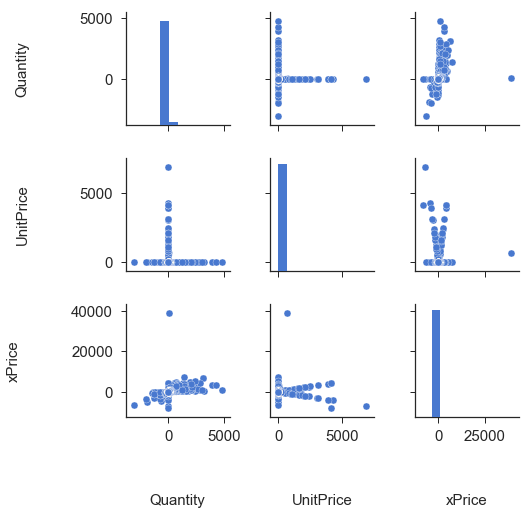

In [28]:
sns.pairplot(df[['Quantity', 'UnitPrice', 'xPrice']])
plt.show()

### Seasonality

How much is sold each month during the time periode

In [146]:
df_month = df[['InvoiceDate', 'Country', 'Quantity', 'xPrice']].set_index(['InvoiceDate']).resample('M').sum()

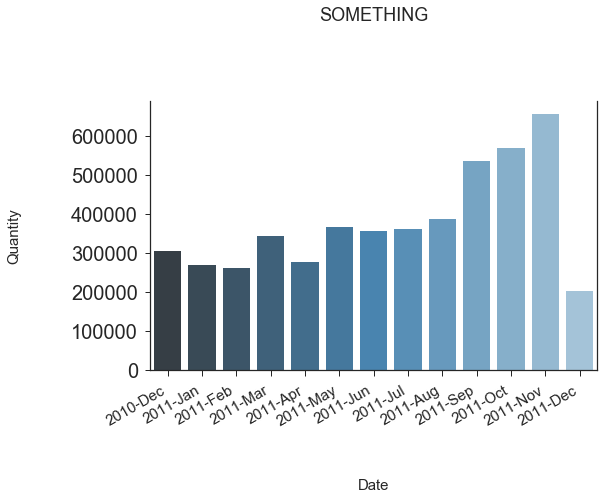

In [145]:
plt.clf()
df_month_test = df_month.reset_index()
ax = sns.barplot(x="InvoiceDate", y="Quantity", data=df_month_test, estimator=sum, palette="Blues_d")

ax.set_title('SOMETHING')
ax.set_ylabel('Quantity')
ax.set_xlabel('Date')

ax.set_xticklabels(df_month_test.InvoiceDate.dt.strftime('%Y-%b'))

plt.xticks(rotation=30, size=15)
plt.yticks(size=20)

plt.gcf().autofmt_xdate()

plt.show()

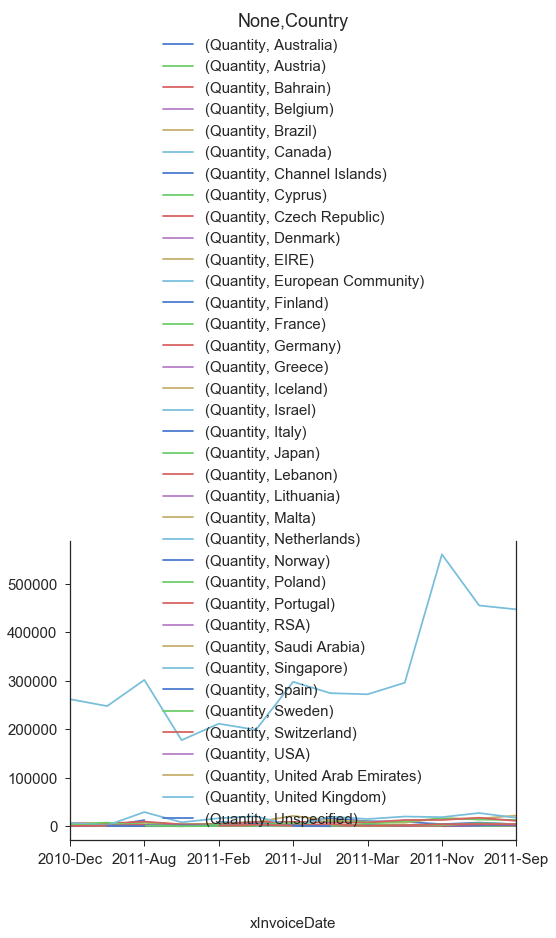

In [206]:
df_test2 = df[['Country', 'InvoiceDate', 'Quantity']].copy()
df_test2['xInvoiceDate'] = df_test2.InvoiceDate.dt.strftime('%Y-%b')
df_test2 = df_test2.groupby(['Country', 'xInvoiceDate']).sum()
df_test2.unstack(level=0).plot()
plt.show()


In [210]:
df_test2.unstack(level=0).head(20)

Quantity                                                         \
Country      Australia Austria Bahrain Belgium Brazil  Canada Channel Islands   
xInvoiceDate                                                                    
2010-Dec         454.0     0.0     NaN  1742.0    NaN     NaN            80.0   
2011-Apr         116.0   308.0     NaN  1162.0  356.0     NaN            97.0   
2011-Aug       12570.0   788.0     NaN  2034.0    NaN    52.0          2008.0   
2011-Dec           NaN   144.0     NaN  1089.0    NaN     NaN            59.0   
2011-Feb        8659.0   340.0     NaN  1080.0    NaN     NaN           935.0   
2011-Jan        5644.0     NaN     NaN   775.0    NaN     NaN           255.0   
2011-Jul        5185.0   571.0     NaN  1660.0    NaN  1026.0             NaN   
2011-Jun       15973.0    -6.0     NaN  2216.0    NaN  1092.0           836.0   
2011-Mar       10329.0   972.0     NaN  1753.0    NaN    88.0          2104.0   
2011-May        9073.0   471.0   260.0  1809.0    NaN   504.0           221.0   
2011-Nov        4206.0   714.0     NaN  2508.0    NaN     NaN           714.0   
2011-Oct        7401.0   488.0     NaN  3123.0    NaN     NaN          1407.0   
2011-Sep        4043.0     NaN     NaN  1929.0    NaN     NaN           763.0   

                                                ...                          \
Country       Cyprus Czech Republic Denmark     ...        RSA Saudi Arabia   
xInvoiceDate                                    ...                           
2010-Dec       917.0            NaN   446.0     ...        NaN          NaN   
2011-Apr        -4.0          -39.0     NaN     ...        NaN          NaN   
2011-Aug         NaN            NaN   328.0     ...        NaN          NaN   
2011-Dec        -6.0            NaN   172.0     ...        NaN          NaN   
2011-Feb      2189.0          346.0   222.0     ...        NaN         80.0   
2011-Jan       144.0            NaN     NaN     ...        NaN          NaN   
2011-Jul         NaN            NaN   240.0     ...        NaN          NaN   
2011-Jun       356.0            NaN  1533.0     ...        NaN          NaN   
2011-Mar      1005.0            NaN   879.0     ...        NaN         -5.0   
2011-May         NaN            NaN   366.0     ...        NaN          NaN   
2011-Nov       300.0          -39.0  1537.0     ...        NaN          NaN   
2011-Oct      1382.0          324.0   820.0     ...      352.0          NaN   
2011-Sep        33.0            NaN  1604.0     ...        NaN          NaN   

                                                           \
Country      Singapore   Spain  Sweden Switzerland    USA   
xInvoiceDate                                                
2010-Dec           NaN   862.0  3714.0       712.0    NaN   
2011-Apr        1384.0   948.0   306.0       770.0  137.0   
2011-Aug           NaN  1582.0  1302.0      2958.0    NaN   
2011-Dec           NaN   255.0     0.0         NaN  408.0   
2011-Feb           NaN   852.0   249.0      1098.0    NaN   
2011-Jan        1091.0  3823.0  3092.0      2988.0    NaN   
2011-Jul        2160.0  3420.0  6004.0      1483.0    NaN   
2011-Jun           NaN  1515.0   399.0      3956.0    NaN   
2011-Mar           NaN  2519.0  5262.0       979.0    NaN   
2011-May           NaN  1448.0  2828.0      2241.0    NaN   
2011-Nov           NaN  3431.0  1954.0      3770.0    NaN   
2011-Oct         599.0  3305.0  6148.0      4502.0  489.0   
2011-Sep           NaN  2655.0  4342.0      4224.0    NaN   

                                                              
Country      United Arab Emirates United Kingdom Unspecified  
xInvoiceDate                                                  
2010-Dec                      NaN       262175.0         NaN  
2011-Apr                      NaN       247919.0       282.0  
2011-Aug                      NaN       301935.0       185.0  
2011-Dec                      NaN       177585.0         NaN  
2011-Feb                    496.0 

In [ ]:
sns.jointplot(x="Quantity", y="xPrice", marginal_kws=dict(bins=15, rug=True), data=df)
plt.show()

In [ ]:
#df['xPrice'].plot(kind='hist', bins=100).set_title('sdsdfsdf', fontsize='xx-large')

#df[['Quantity']].plot(kind="kde")

ax = sns.distplot(df['Quantity'], bins=100, kde=False)
ax.set_title('Some title', fontsize='large')
ax.set_ylabel('Frequency')

sns.despine(offset=10)
plt.show()

In [ ]:
#df.plot.scatter(x='Quantity', y='xPrice')

sns.regplot(x="Quantity", y="xPrice", fit_reg=True, data=df[['Quantity', 'xPrice']])
##sns.despine(offset=10, left=False, bottom=False) # removes top and right border
plt.show()

In [ ]:
sns.lmplot(
    x="Quantity", 
    y="xPrice", 
    fit_reg=True, 
    #hue='Country', 
    data=df[['Quantity', 'xPrice', 'Country']])
sns.despine(offset=10)
plt.show()

In [ ]:
#sns.lmplot(x="total_bill", y="tip", col="day", hue="day", data=tips, col_wrap=2, size=3)
sns.lmplot(
    x="Quantity", 
    y="xPrice", 
    hue='Country', 
    col='Country',
    col_wrap=5,
    fit_reg=True, 
    data=df[['Quantity', 'xPrice', 'Country']])
plt.show()

In [ ]:
ax = sns.boxplot(x="Country", y="xPrice", width=30, data=df)
ax.set_title('SOMETHING')
plt.xticks(rotation=30, size=15)
plt.yticks(size=20)
plt.show()

In [ ]:
df_month = df[['InvoiceDate', 'Country', 'xPrice']].set_index(['InvoiceDate']).resample('M').sum()

fig, ax = plt.subplots(figsize=(10,5), ncols=2)

df_month.plot(kind='bar', ax=ax[0])
df_month.plot(ax=ax[1])

plt.show()

In [ ]:
df_month.plot()

In [ ]:
df.info()